# First Solve Lagrangian Equation
This is used to determine the equations of motion for a system based on its kinetic and potential energies.

L = T - V
Where:
- L is the Lagrangian
- T is the kinetic energy
- V is the potential energy

### Import Libraries

In [27]:
from sympy import symbols, Function, diff, simplify, Eq, dsolve, solve, pprint, latex, sqrt, Matrix, det, Rational
from sympy.physics.mechanics import dynamicsymbols
from sympy import cos, sin
import numpy as np

#plotting
import matplotlib.pyplot as plt

# for displaying equations in LaTeX
from IPython.display import Math

# for dataframes and tables
import pandas as pd

### `solve_lagrangian(T, V, coords)`

Solve a Lagrangian mechanics problem using the Euler–Lagrange equations.

---

#### **Parameters**
| Name | Type | Description |
|------|------|-------------|
| **T** | `sympy` expression | Kinetic energy as a function of generalized coordinates and velocities. |
| **V** | `sympy` expression | Potential energy as a function of generalized coordinates. |
| **coords** | list of `dynamicsymbols` | Generalized coordinates, e.g. `[q1, q2, ...]`. |

---

#### **Returns**
| Name | Type | Description |
|------|------|-------------|
| **equations** | list of `sympy.Eq` | Euler–Lagrange equations for each coordinate. |

---

#### **Notes**
The function computes equations of motion using:
$$

\frac{d}{dt}\left( \frac{\partial \mathcal{L}}{\partial \dot{q}_i} \right)
\;-\;
\frac{\partial \mathcal{L}}{\partial q_i}
= 0

$$
where
$$  

\mathcal{L} = T - V.
$$
---


In [28]:
def solve_lagrangian_system(T, V, coords):
    """

    """
    t = symbols('t')
    
    # Define Lagrangian
    L = T - V

    L = simplify(L)
    
    print("Lagrangian L = T - V:")
    display(Math(r"L = " + latex(L)))
    
    # Compute Euler-Lagrange equations for each coordinate
    equations = []
    
    for q in coords:
        q_dot = diff(q, t)
        
        # Compute ∂L/∂q̇
        dL_dqdot = diff(L, q_dot)
        
        # Compute d/dt(∂L/∂q̇)
        d_dt_dL_dqdot = diff(dL_dqdot, t)
        
        # Compute ∂L/∂q
        dL_dq = diff(L, q)
        
        # Euler-Lagrange equation: d/dt(∂L/∂q̇) - ∂L/∂q = 0
        EL_eq = Eq(d_dt_dL_dqdot - dL_dq, 0)
        
        # Simplify the equation
        EL_eq = simplify(EL_eq)

        equations.append(EL_eq)
        pprint(f"Euler-Lagrange equation for {q}:")
        display(Math(latex((EL_eq))))
        
    
    return equations

## Central Difference Method
This method is used for numerically solving differential equations, particularly in structural dynamics.
### `central_difference(M, K, F, u0, v0, dt, t_end)`
Perform time integration using the central difference method.
---
#### **Parameters**
| Name | Type | Description |
|------|------|-------------|
| **M** | `sympy` Matrix | Mass matrix of the system. |
| **K** | `sympy` Matrix | Stiffness matrix of the system. |
| **F** | `sympy` Matrix | External force vector as a function of time. |
| **u0** | `sympy` Matrix | Initial displacement vector. |
| **v0** | `sympy` Matrix | Initial velocity vector. |
| **dt** | `float` | Time step for integration. |
| **t_end** | `float` | End time for simulation. |
---
#### **Returns**
| Name | Type | Description |
|------|------|-------------|
| **u** | `list` of `sympy` Matrices | Displacement history over time. |
| **v** | `list` of `sympy` Matrices | Velocity history over time. |
| **a** | `list` of `sympy` Matrices | Acceleration history over time. |
---
#### **Notes**
The central difference method approximates the second derivative using finite differences, allowing for time integration of the equations of motion:
$$
M \ddot{u}(t) + K u(t) = F(t)
$$
---

In [29]:
def central_difference(M, K, F, u0, v0, dt, t_end):
    """
    Central Difference Method for M u'' + K u = F(t)
    
    Parameters
    ----------
    M : (n,n) array_like
        Mass matrix
    K : (n,n) array_like
        Stiffness matrix
    F : function
        Function of time returning force vector, F(t)
    u0 : (n,) array_like
        Initial displacement
    v0 : (n,) array_like
        Initial velocity
    dt : float
        Time step
    t_end : float
        End time

    Returns
    -------
    u : (n, num_steps) ndarray
        Displacements
    v : (n, num_steps) ndarray
        Velocities
    a : (n, num_steps) ndarray
        Accelerations
    """
    M = np.array(M, dtype=float)
    K = np.array(K, dtype=float)
    u0 = np.array(u0, dtype=float).flatten()
    v0 = np.array(v0, dtype=float).flatten()
    
    num_dof = M.shape[0]
    num_steps = int(t_end / dt) + 1
    
    # Precompute inverse mass
    M_inv = np.linalg.inv(M)
    
    # Allocate arrays
    u = np.zeros((num_dof, num_steps))
    v = np.zeros((num_dof, num_steps))
    a = np.zeros((num_dof, num_steps))
    
    # Initial conditions
    u[:, 0] = u0
    v[:, 0] = v0
    F0 = np.array(F(0), dtype=float).flatten()
    
    # Initial acceleration
    a[:, 0] = M_inv @ (F0 - K @ u0)
    
    # "Ghost step" for n = -1 (first step)
    u_minus1 = u0 - dt * v0 + 0.5 * dt**2 * (-M_inv @ (K @ u0 - F0))
    
    # Time integration
    for n in range(num_steps - 1):
        t_n1 = (n + 1) * dt
        F_n1 = np.array(F(t_n1), dtype=float).flatten()
        
        # Central difference displacement update
        u[:, n + 1] = dt**2 * M_inv @ (F_n1 - K @ u[:, n]) + 2 * u[:, n] - u_minus1
        
        # Velocity update (approximate)
        v[:, n + 1] = (u[:, n + 1] - u_minus1) / (2 * dt)
        
        # Acceleration update
        a[:, n + 1] = M_inv @ (F_n1 - K @ u[:, n + 1])
        
        # Shift ghost step
        u_minus1 = u[:, n]
    
    return u, v, a


## Houbolt Method for Time Integration
This method is used for numerically solving second-order differential equations, particularly in structural dynamics.
### `houbolt_method(M, K, F, u0, v0, dt, t_end)`
Perform time integration using the Houbolt method.
---
#### **Parameters**
| Name | Type | Description |
|------|------|-------------|
| **M** | `sympy` Matrix | Mass matrix of the system. |
| **K** | `sympy` Matrix | Stiffness matrix of the system. |
| **F** | `sympy` Matrix | External force vector as a function of time. |
| **u0** | `sympy` Matrix | Initial displacement vector. |
| **v0** | `sympy` Matrix | Initial velocity vector. |
| **dt** | `float` | Time step for integration. |
| **t_end** | `float` | End time for simulation. |
---
#### **Returns**
| Name | Type | Description |
|------|------|-------------|
| **u** | list of `sympy` Matrices | Displacement vectors at each time step. |
| **v** | list of `sympy` Matrices | Velocity vectors at each time step. |
| **a** | list of `sympy` Matrices | Acceleration vectors at each time step. |
---
#### **Notes**
The Houbolt method is an implicit time integration scheme that provides stability for solving the equations of motion:
$$

In [30]:
def houbolt(M, K, F, u0, v0, dt, t_end):
    """
    Houbolt Method for M u'' + K u = F(t)
    
    Parameters
    ----------
    M : (n,n) array_like
        Mass matrix
    K : (n,n) array_like
        Stiffness matrix
    F : function
        Function of time returning force vector, F(t)
    u0 : (n,) array_like
        Initial displacement
    v0 : (n,) array_like
        Initial velocity
    dt : float
        Time step
    t_end : float
        End time

    Returns
    -------
    u : (n, num_steps) ndarray
        Displacements
    v : (n, num_steps) ndarray
        Velocities
    a : (n, num_steps) ndarray
        Accelerations
    """
    M = np.array(M, dtype=float)
    K = np.array(K, dtype=float)
    u0 = np.array(u0, dtype=float).flatten()
    v0 = np.array(v0, dtype=float).flatten()
    
    n_dof = M.shape[0]
    n_steps = int(t_end/dt) + 1
    
    # Allocate arrays
    u = np.zeros((n_dof, n_steps))
    v = np.zeros((n_dof, n_steps))
    a = np.zeros((n_dof, n_steps))
    
    # Initial acceleration
    F0 = np.array(F(0), dtype=float).flatten()
    # Ensure M is invertible or use solve
    a0 = np.linalg.solve(M, F0 - K @ u0)
    
    # --- STEP 2 & 3: Initialization of Ghost Points ---
    # Derived via CDM (u-1) and 3-point Backward Velocity (u-2)
    u_minus1 = u0 - dt*v0 + 0.5*dt**2*a0
    u_minus2 = u0 - 2*dt*v0 + 2*dt**2*a0
    
    # Initialize first step
    u[:,0] = u0
    v[:,0] = v0
    a[:,0] = a0
    
    # Coefficient for Mass in effective stiffness is 2/dt^2
    alpha = 2.0 
    A = alpha * M / dt**2 + K

    # Time integration
    for n in range(n_steps-1):
        t_np1 = (n+1)*dt
        F_np1 = np.array(F(t_np1), dtype=float).flatten()
        
        # Using coefficients 5, -4, 1 for the history terms
        rhs = F_np1 + M @ (5*u[:,n] - 4*u_minus1 + u_minus2) / dt**2
        
        u_next = np.linalg.solve(A, rhs)
        
        # Velocity and acceleration 
        if n >= 0: 
            a[:, n+1] = (2*u_next - 5*u[:,n] + 4*u_minus1 - u_minus2) / dt**2
            v[:, n+1] = (11*u_next - 18*u[:,n] + 9*u_minus1 - 2*u_minus2) / (6*dt)
        
        # Shift steps
        u_minus2 = u_minus1
        u_minus1 = u[:,n]
        u[:,n+1] = u_next
        
    return u, v, a

## Create function for Analytical Solution of 2DOF System

In [31]:
x_t = lambda t: 0.5*(np.cos(30*t) - np.cos(33.166*t))
theta_t = lambda t: 0.5*(np.cos(30*t) + np.cos(33.166*t))

## Plot the results

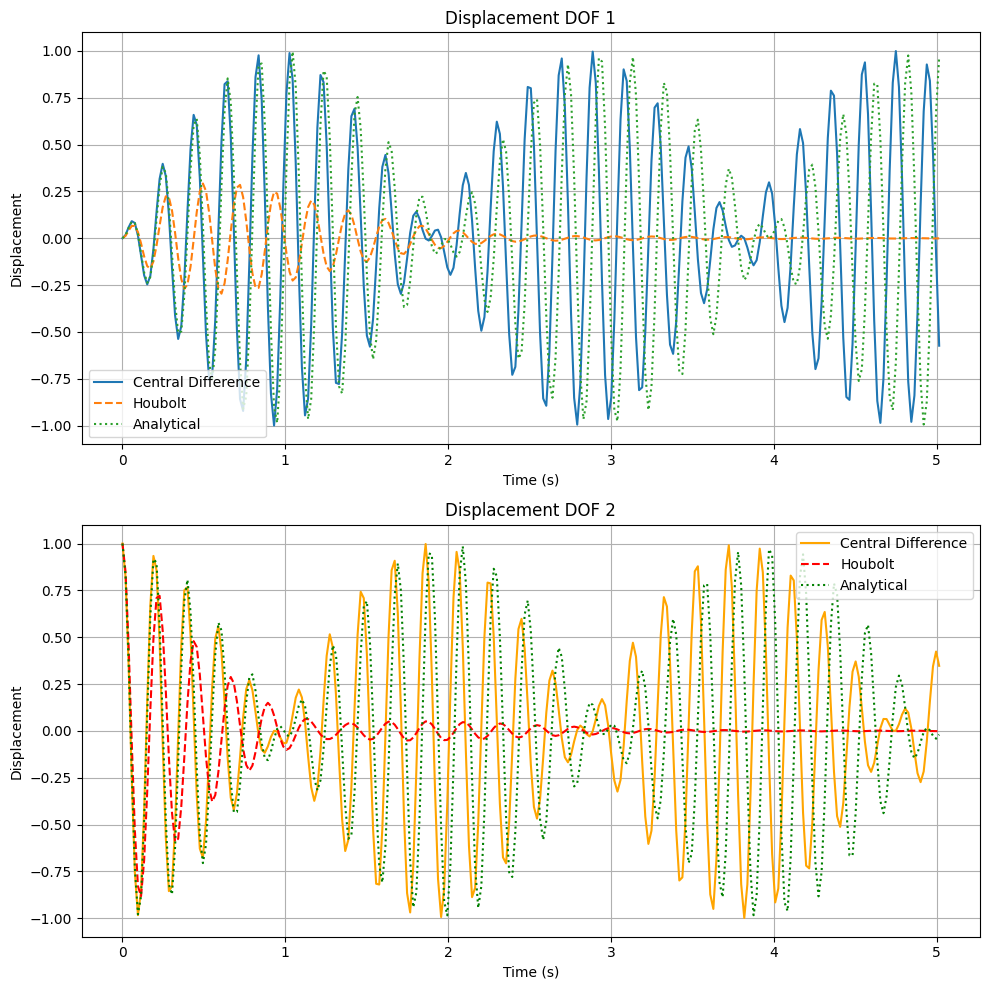

In [32]:
# Timesteps

time_max = 5.0
dt = 0.019 # taken from the smallest value obtained from 2pi/omega_n


M_matrix = np.array([[1, 0],
                     [0, 1]])
K_matrix = np.array([[1000, -100],
                     [-100, 1000]])

u_central, v_central, a_central = central_difference(M_matrix, K_matrix, lambda t: np.array([0, 0]), [0, 1], [0, 0], dt, time_max + dt)

u_houbolt, v_houbolt, a_houbolt = houbolt(M_matrix, K_matrix, lambda t: np.array([0, 0]), [0, 1], [0, 0], dt, time_max + dt)

# also get u v and a from analytical solution for comparison
t = np.arange(0, time_max + dt, dt)
u_analytical = np.array([x_t(t), theta_t(t)])

plt.figure(figsize=(10,10))

# DOF 1
plt.subplot(2, 1, 1)
plt.plot(t, u_central[0, :], label='Central Difference')
plt.plot(t, u_houbolt[0, :], label='Houbolt', linestyle='--')
plt.plot(t, u_analytical[0, :], label='Analytical', linestyle=':')
plt.title('Displacement DOF 1')
plt.xlabel('Time (s)')
plt.ylabel('Displacement')
plt.legend()
plt.grid()

# DOF 2
plt.subplot(2, 1, 2)
plt.plot(t, u_central[1, :], label='Central Difference', color='orange')
plt.plot(t, u_houbolt[1, :], label='Houbolt', linestyle='--', color='red')
plt.plot(t, u_analytical[1, :], label='Analytical', linestyle=':', color='green')
plt.title('Displacement DOF 2')
plt.xlabel('Time (s)')
plt.ylabel('Displacement')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show() 


## create lovely tables
We do this using pandas dataframes for better visualization of results.

In [33]:
df = pd.DataFrame({
    'Time (s)': t,
    'Analytical DOF 1': u_analytical[0, :],
    'Analytical DOF 2': u_analytical[1, :],
    'Central Difference DOF 1': u_central[0, :],
    'Central Difference DOF 2': u_central[1, :],
    'Houbolt DOF 1': u_houbolt[0, :],
    'Houbolt DOF 2': u_houbolt[1, :],
})

display(df.head(10))

,Time (s),Analytical DOF 1,Analytical DOF 2,Central Difference DOF 1,Central Difference DOF 2,Houbolt DOF 1,Houbolt DOF 2
0,0.000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.019,0.016982,0.824919,0.018050,0.819500,0.012955,0.847297
2,0.038,0.056035,0.361559,0.059168,0.343812,0.041930,0.447902
3,0.057,0.087747,-0.226502,0.091338,-0.253856,0.065893,-0.062387
4,0.076,0.081040,-0.732270,0.081371,-0.756585,0.065876,-0.531076
5,0.095,0.021085,-0.978873,0.014716,-0.983249,0.032959,-0.828776
6,0.114,-0.079500,-0.881995,-0.092747,-0.854429,-0.027389,-0.882232
7,0.133,-0.182203,-0.478976,-0.197572,-0.420508,-0.096499,-0.690647
8,0.152,-0.237374,0.085574,-0.246255,0.158083,-0.148911,-0.321244
9,0.171,-0.206519,0.612097,-0.200333,0.670717,-0.161731,0.113637
